In [3]:
# download model
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "reciprocate/dahoas-gptj-rm-static"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# download SAEs
from huggingface_hub import hf_hub_download
from dictionary import GatedAutoEncoder

# import sys
# sys.path.append("/root/dictionary_learning/")

layers = [2,8,12,14,16,20]
activation_names = [f"transformer.h.{layer}" for layer in layers]
model_id = "Elriggs/rm"
saes = []
for layer in layers:
    sae_filename = f"ae_layer{layer}.pt"
    ae_download_location = hf_hub_download(repo_id=model_id, filename=sae_filename)
    saes.append(GatedAutoEncoder.from_pretrained(ae_download_location).to(device))

Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.73s/it]


In [4]:
# download dataset
from datasets import load_dataset
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

dataset_name = "stas/openwebtext-10k"
max_seq_length = 40
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=7000) # num_datapoints grabs all of them if None

In [29]:
# Save metrics
import torch
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from baukit import TraceDict
batch_size = 32
l0s = [[] for _ in layers]
cos_sims = [[] for _ in layers]
fvus = [[] for _ in layers]
l2_ratios = [[] for _ in layers]
variances = [[] for _ in layers]
with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.device)
        with TraceDict(model, activation_names) as ret:
            _ = model(batch).logits
        for layer_ind, layer in enumerate(layers):
            internal_activations = ret[activation_names[layer_ind]].output
            # check if instance tuple
            if(isinstance(internal_activations, tuple)):
                internal_activations = internal_activations[0]
            
            sae = saes[layer_ind]    
            x = rearrange(internal_activations, "b s n -> (b s) n" )
            features = sae.encode(x)
            x_hat = sae.decode(features)
            l0 = (features != 0).sum(-1).float().mean().item()
            cos_sim = torch.nn.functional.cosine_similarity(x, x_hat, dim=-1).mean().item()
            fvu = ((x - x_hat) ** 2).mean() / x.var()
            var = x.var().item()
            l2_ratio = (torch.norm(x, p=2, dim=-1) / torch.norm(x_hat, p=2, dim=-1)).mean().item()
            l0s[layer_ind].append(l0)
            cos_sims[layer_ind].append(cos_sim)
            fvus[layer_ind].append(fvu.item())
            l2_ratios[layer_ind].append(l2_ratio)     
            variances[layer_ind].append(var)
# batch_size = 128
# dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, activation_name, max_seq_length, ae, batch_size=batch_size)

  0%|          | 0/219 [00:00<?, ?it/s]

100%|██████████| 219/219 [04:13<00:00,  1.16s/it]


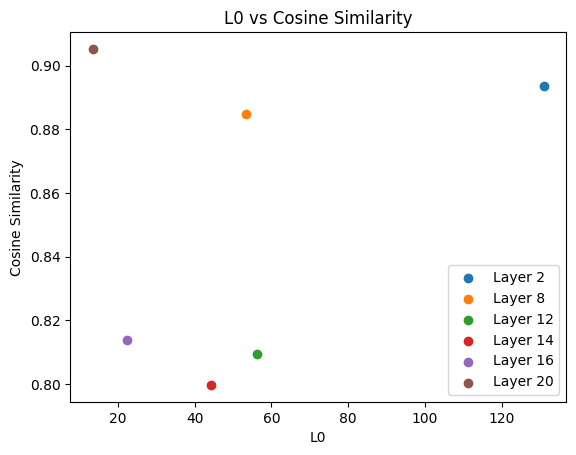

In [23]:
# Plot l0 vs cos_sim for each, overlapping in a scatter plot
import matplotlib.pyplot as plt

for layer_ind, layer in enumerate(layers):
    
    # plt.scatter(l0s[layer_ind], cos_sims[layer_ind], label=f"Layer {layer}")
    # above but mean of each
    l0 = sum(l0s[layer_ind])/len(l0s[layer_ind])
    cos_sim = sum(cos_sims[layer_ind])/len(cos_sims[layer_ind])
    plt.scatter(l0, cos_sim, label=f"Layer {layer}")
plt.xlabel("L0")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.title("L0 vs Cosine Similarity")
plt.show()

In [32]:
for layer_ind, layer in enumerate(layers):
    
    # plt.scatter(l0s[layer_ind], cos_sims[layer_ind], label=f"Layer {layer}")
    # above but mean of each
    l0 = sum(l0s[layer_ind])/len(l0s[layer_ind])
    print(f"Layer {layer} L0: {l0:.0f}")

Layer 2 L0: 131
Layer 8 L0: 53
Layer 12 L0: 56
Layer 14 L0: 44
Layer 16 L0: 22
Layer 20 L0: 13


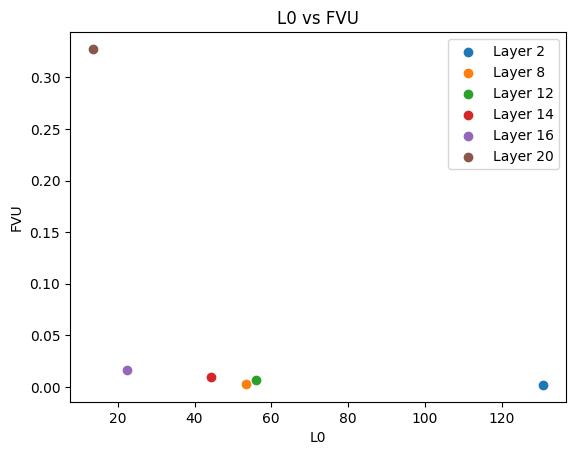

In [24]:
# also plot l0 vs fvu
for layer_ind, layer in enumerate(layers):
    l0 = sum(l0s[layer_ind])/len(l0s[layer_ind])
    fvu = sum(fvus[layer_ind])/len(fvus[layer_ind])
    plt.scatter(l0, fvu, label=f"Layer {layer}")
plt.xlabel("L0")
plt.ylabel("FVU")
plt.legend()
plt.title("L0 vs FVU")
plt.show()

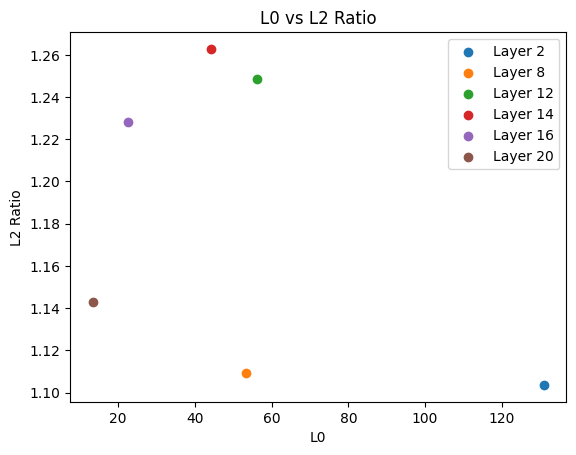

In [25]:
# also plot l0 vs l2_ratio
for layer_ind, layer in enumerate(layers):
    l0 = sum(l0s[layer_ind])/len(l0s[layer_ind])
    l2_ratio = sum(l2_ratios[layer_ind])/len(l2_ratios[layer_ind])
    plt.scatter(l0, l2_ratio, label=f"Layer {layer}")
plt.xlabel("L0")
plt.ylabel("L2 Ratio")
plt.legend()
plt.title("L0 vs L2 Ratio")
plt.show()

Text(0.5, 1.0, 'FVU vs Cosine Similarity')

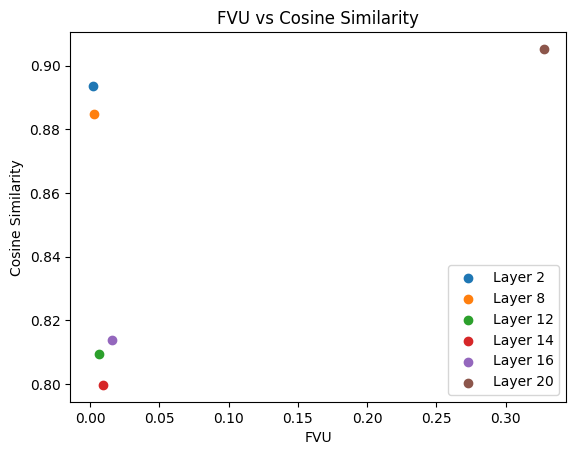

In [28]:
# now FVU vs cos sim. Color by L0
for layer_ind, layer in enumerate(layers):
    # l0 = sum(l0s[layer_ind])/len(l0s[layer_ind])
    fvu = sum(fvus[layer_ind])/len(fvus[layer_ind])
    cos_sim = sum(cos_sims[layer_ind])/len(cos_sims[layer_ind])
    plt.scatter(fvu, cos_sim,  label=f"Layer {layer}")
plt.xlabel("FVU")
plt.ylabel("Cosine Similarity")
# plt.colorbar()
plt.legend()
plt.title("FVU vs Cosine Similarity")

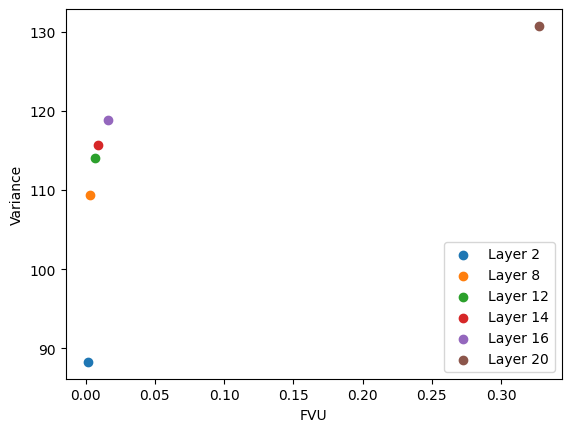

In [30]:
# plot var by fvu
for layer_ind, layer in enumerate(layers):
    fvu = sum(fvus[layer_ind])/len(fvus[layer_ind])
    var = sum(variances[layer_ind])/len(variances[layer_ind])
    plt.scatter(fvu, var, label=f"Layer {layer}")
plt.xlabel("FVU")
plt.ylabel("Variance")
plt.legend()

In [21]:
x.shape, features.shape, x_hat.shape
cos_sim = torch.nn.functional.cosine_similarity(x_hat, x, dim=-1).mean().item()
features.shape
(features != 0).sum(-1).float().mean().item(), (features != 0).sum(-1).float()
# norm of x_hat/ x
l2_ratio = (torch.norm(x_hat, dim=-1)/ torch.norm(x, dim=-1)).mean().item()
l2_ratio
fvu = ((x - x_hat)**2).mean() / (x**2).mean()

tensor(0.0019, device='cuda:0')

In [19]:
x_hat.shape, torch.norm(x_hat, dim=-1).shape, features.shape

(torch.Size([1280, 4096]), torch.Size([1280]), torch.Size([1280, 32768]))